In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        paths.append(path)

# Two .csv is not useful
# sample_submission.csv, HomeCredit_columns_description.csv

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# 1. Data Exploration

In [3]:
paths.remove("/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv")

# for path in paths:
#     try:
#         data = pd.read_csv(path)
#         print(f"\nData from {path}:")
#         # print(data.head())
#         print(data.columns)
#     except Exception as e:
#         print(f"Could not read {path}: {e}")

In [4]:
train_df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
print(train_df.shape)
test_df = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
print(test_df.shape)

(307511, 122)
(48744, 121)


# 2. Feature Engineering

Idea: Apply aggreagtion to different tables as additional features to feed into the training set

## bureau.csv

In [5]:
# --- bureau ---

df_bureau = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau.csv")
print(df_bureau.columns)

bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',                          # Total external loans
    'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(), # Active loans count
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],          # Total/avg external debt
    'AMT_CREDIT_SUM_OVERDUE': 'max',                 # Max overdue amount
    'CREDIT_DAY_OVERDUE': 'max',                     # Worst delinquency (days)
    'DAYS_CREDIT': ['min', 'max']                    # Oldest/newest credit line
}).reset_index()

bureau_agg.columns = ['_'.join(col).strip() for col in bureau_agg.columns]
bureau_agg = bureau_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'})
bureau_agg

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')


,SK_ID_CURR,SK_ID_BUREAU_count,CREDIT_ACTIVE_<lambda>,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,DAYS_CREDIT_min,DAYS_CREDIT_max
0,100001,7,3,596686.500,85240.928571,0.0,0,-1572,-49
1,100002,8,2,245781.000,49156.200000,0.0,0,-1437,-103
2,100003,4,1,0.000,0.000000,0.0,0,-2586,-606
3,100004,2,0,0.000,0.000000,0.0,0,-1326,-408
4,100005,3,2,568408.500,189469.500000,0.0,0,-373,-62
...,...,...,...,...,...,...,...,...,...
305806,456249,13,2,163071.000,16307.100000,0.0,0,-2713,-483
305807,456250,3,2,2232040.095,744013.365000,0.0,0,-1002,-760
305808,456253,4,2,1795833.000,448958.250000,0.0,0,-919,-713
305809,456254,1,0,0.000,0.000000,0.0,0,-1104,-1104


## bureau_balance.csv

In [6]:
df_bureau_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/bureau_balance.csv")
print(df_bureau_balance.columns)

df_bureau_balance['DELINQUENT'] = (df_bureau_balance['STATUS'] >= '1').astype(int) # delinquency flags per loan

loan_status_agg = df_bureau_balance.groupby('SK_ID_BUREAU').agg({
    'DELINQUENT': 'mean',                            # % of months delinquent
    'MONTHS_BALANCE': ['min', 'max']                 # Account age
}).reset_index()

loan_status_agg.columns = [
    'SK_ID_BUREAU', 
    'DELINQUENT_mean',
    'MONTHS_BALANCE_min',
    'MONTHS_BALANCE_max'
]

# Merge with bureau.csv and roll up to client level
client_delinquency = df_bureau.merge(loan_status_agg, on='SK_ID_BUREAU', how='left')
client_delinquency_agg = client_delinquency.groupby('SK_ID_CURR')['DELINQUENT_mean'].mean().reset_index()

client_delinquency_agg

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,SK_ID_CURR,DELINQUENT_mean
0,100001,0.663349
1,100002,0.593040
2,100003,NaN
3,100004,NaN
4,100005,0.264957
...,...,...
305806,456249,NaN
305807,456250,0.869741
305808,456253,0.595094
305809,456254,0.783784


### previous_application.csv

In [7]:
df_prev_application = pd.read_csv("/kaggle/input/home-credit-default-risk/previous_application.csv")
print(df_prev_application.columns)

prev_agg = df_prev_application.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',                           # Total past applications
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').mean(), # Approval rate
    'AMT_CREDIT': ['sum', 'mean'],                   # Total/avg loan amount
    'NAME_CASH_LOAN_PURPOSE': lambda x: x.mode()[0]  # Most frequent purpose
}).reset_index()

prev_agg.columns = ['_'.join(col).strip() for col in prev_agg.columns]
prev_agg = prev_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'})
prev_agg

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')


,SK_ID_CURR,SK_ID_PREV_count,NAME_CONTRACT_STATUS_<lambda>,AMT_CREDIT_sum,AMT_CREDIT_mean,NAME_CASH_LOAN_PURPOSE_<lambda>
0,100001,1,1.00,23787.0,23787.00,XAP
1,100002,1,1.00,179055.0,179055.00,XAP
2,100003,3,1.00,1452573.0,484191.00,XAP
3,100004,1,1.00,20106.0,20106.00,XAP
4,100005,2,0.50,40153.5,20076.75,XAP
...,...,...,...,...,...,...
338852,456251,1,1.00,40455.0,40455.00,XAP
338853,456252,1,1.00,56821.5,56821.50,XAP
338854,456253,2,1.00,41251.5,20625.75,XAP
338855,456254,2,1.00,268879.5,134439.75,XAP


## POS_CASH_balance.csv

In [8]:
df_POS_CASH_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv")
print(df_POS_CASH_balance.columns)

pos_agg = df_POS_CASH_balance.groupby('SK_ID_CURR').agg({
    'NAME_CONTRACT_STATUS': lambda x: (x == 'Active').mean(), # % active accounts
    'SK_DPD': 'max',                                # Worst delinquency (days)
    'CNT_INSTALMENT': 'mean'                        # Avg installment count
}).reset_index()
pos_agg

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')


,SK_ID_CURR,NAME_CONTRACT_STATUS,SK_DPD,CNT_INSTALMENT
0,100001,0.777778,7,4.000000
1,100002,1.000000,0,24.000000
2,100003,0.928571,0,10.107143
3,100004,0.750000,0,3.750000
4,100005,0.818182,0,11.700000
...,...,...,...,...
337247,456251,0.777778,0,7.875000
337248,456252,0.857143,0,6.000000
337249,456253,0.882353,5,6.705882
337250,456254,1.000000,0,14.900000


## installments_payments.csv

In [9]:
# Calculate payment delay (days)
df_installments_payments = pd.read_csv("/kaggle/input/home-credit-default-risk/installments_payments.csv")
print(df_installments_payments.columns)

df_installments_payments['PAYMENT_DELAY'] = \
    df_installments_payments['DAYS_ENTRY_PAYMENT'] - df_installments_payments['DAYS_INSTALMENT']

instal_agg = df_installments_payments.groupby('SK_ID_CURR').agg({
    'PAYMENT_DELAY': ['mean', 'max'],               # Avg/worst delay
    'AMT_PAYMENT': lambda x: (x > 0).mean()         # % of payments made
}).reset_index()

instal_agg.columns = ['_'.join(col).strip() for col in instal_agg.columns]
instal_agg = instal_agg.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'})
instal_agg

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,SK_ID_CURR,PAYMENT_DELAY_mean,PAYMENT_DELAY_max,AMT_PAYMENT_<lambda>
0,100001,-7.285714,11.0,1.0
1,100002,-20.421053,-12.0,1.0
2,100003,-7.160000,-1.0,1.0
3,100004,-7.666667,-3.0,1.0
4,100005,-23.555556,1.0,1.0
...,...,...,...,...
339582,456251,-36.285714,-8.0,1.0
339583,456252,-2.833333,3.0,1.0
339584,456253,-14.500000,9.0,1.0
339585,456254,-19.000000,-8.0,1.0


## credit_card_balance.csv

In [10]:
df_credit_card_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/credit_card_balance.csv")
print(df_credit_card_balance.columns)

cc_agg = df_credit_card_balance.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': 'mean',                          # Avg balance
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',              # Avg credit limit
    'AMT_DRAWINGS_ATM_CURRENT': 'sum',              # Total ATM withdrawals
    'SK_DPD_DEF': 'max'                             # Worst delinquency
}).reset_index()


# Credit utilization ratio
cc_agg['CREDIT_UTILIZATION'] = cc_agg['AMT_BALANCE'] / cc_agg['AMT_CREDIT_LIMIT_ACTUAL']
cc_agg

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')


,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,SK_DPD_DEF,CREDIT_UTILIZATION
0,100006,0.000000,270000.000000,0.0,0,0.000000
1,100011,54482.111149,164189.189189,180000.0,0,0.331825
2,100013,18159.919219,131718.750000,571500.0,1,0.137869
3,100021,0.000000,675000.000000,0.0,0,0.000000
4,100023,0.000000,135000.000000,0.0,0,0.000000
...,...,...,...,...,...,...
103553,456244,131834.730732,296341.463415,1003500.0,0,0.444874
103554,456246,13136.731875,135000.000000,0.0,0,0.097309
103555,456247,23216.396211,144000.000000,202950.0,1,0.161225
103556,456248,0.000000,900000.000000,0.0,0,0.000000


In [11]:
# Merge all features into the main application table
dfs = [bureau_agg, client_delinquency_agg, prev_agg, pos_agg, instal_agg, cc_agg]
for df in dfs:
    train_df = train_df.merge(df, on='SK_ID_CURR', how='left')

dfs = [bureau_agg, client_delinquency_agg, prev_agg, pos_agg, instal_agg, cc_agg]
for df in dfs:
    test_df = test_df.merge(df, on='SK_ID_CURR', how='left')

print(train_df.isnull().sum().sum())  
train_df

11015152


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_DPD,CNT_INSTALMENT,PAYMENT_DELAY_mean,PAYMENT_DELAY_max,AMT_PAYMENT_<lambda>,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,SK_DPD_DEF,CREDIT_UTILIZATION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,24.000000,-20.421053,-12.0,1.0,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,10.107143,-7.160000,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,3.750000,-7.666667,-3.0,1.0,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,12.000000,-19.375000,-1.0,1.0,0.0,270000.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,15.333333,-3.636364,12.0,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,7.875000,-36.285714,-8.0,1.0,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,6.000000,-2.833333,3.0,1.0,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,5.0,6.705882,-14.500000,9.0,1.0,NaN,NaN,NaN,NaN,NaN
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,14.900000,-19.000000,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


# 3. Data Preprocessing

In [12]:
columns = list(set(train_df.columns) - set(test_df.columns))
print(columns)

['TARGET']


SK_ID_CURR                   0.000
TARGET                       0.000
NAME_CONTRACT_TYPE           0.000
DAYS_REGISTRATION            0.000
DAYS_ID_PUBLISH              0.000
                             ...  
AMT_BALANCE                 71.739
AMT_CREDIT_LIMIT_ACTUAL     71.739
SK_DPD_DEF                  71.739
AMT_DRAWINGS_ATM_CURRENT    71.739
CREDIT_UTILIZATION          71.981
Length: 147, dtype: float64


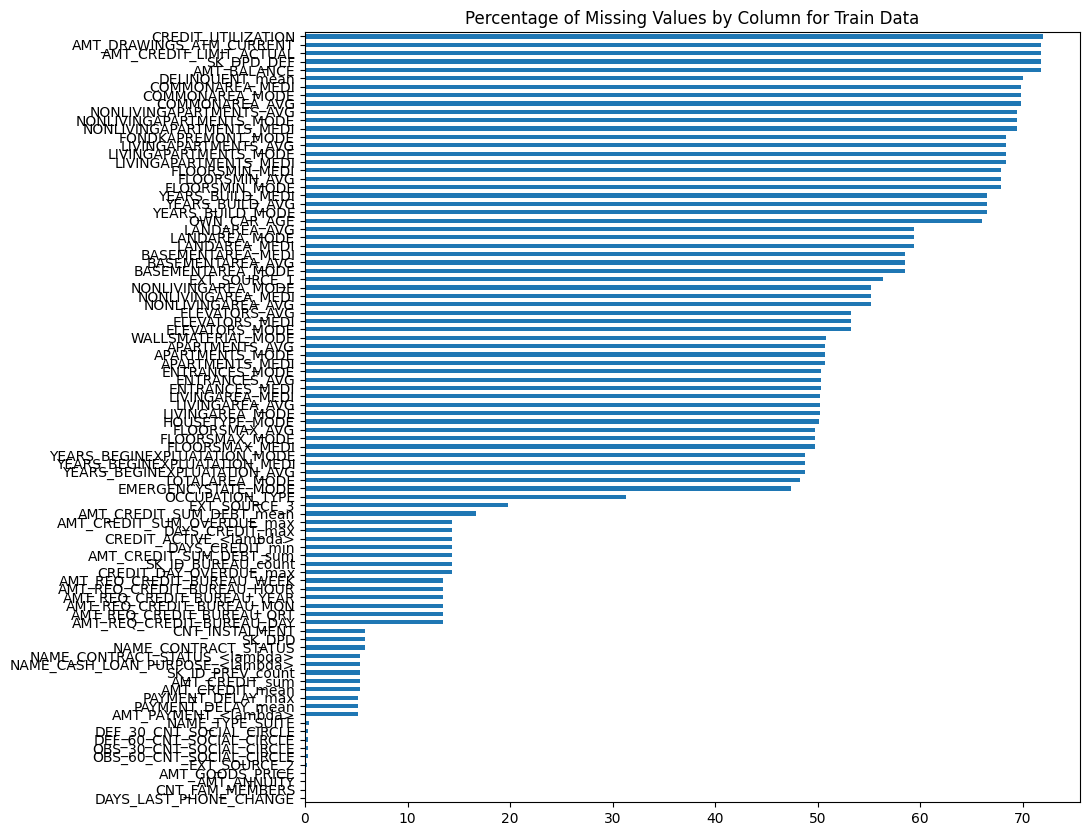

SK_ID_CURR                   0.000
NAME_CONTRACT_TYPE           0.000
NAME_INCOME_TYPE             0.000
NAME_EDUCATION_TYPE          0.000
NAME_FAMILY_STATUS           0.000
                             ...  
NONLIVINGAPARTMENTS_AVG     68.413
NONLIVINGAPARTMENTS_MODE    68.413
COMMONAREA_AVG              68.716
COMMONAREA_MODE             68.716
COMMONAREA_MEDI             68.716
Length: 146, dtype: float64


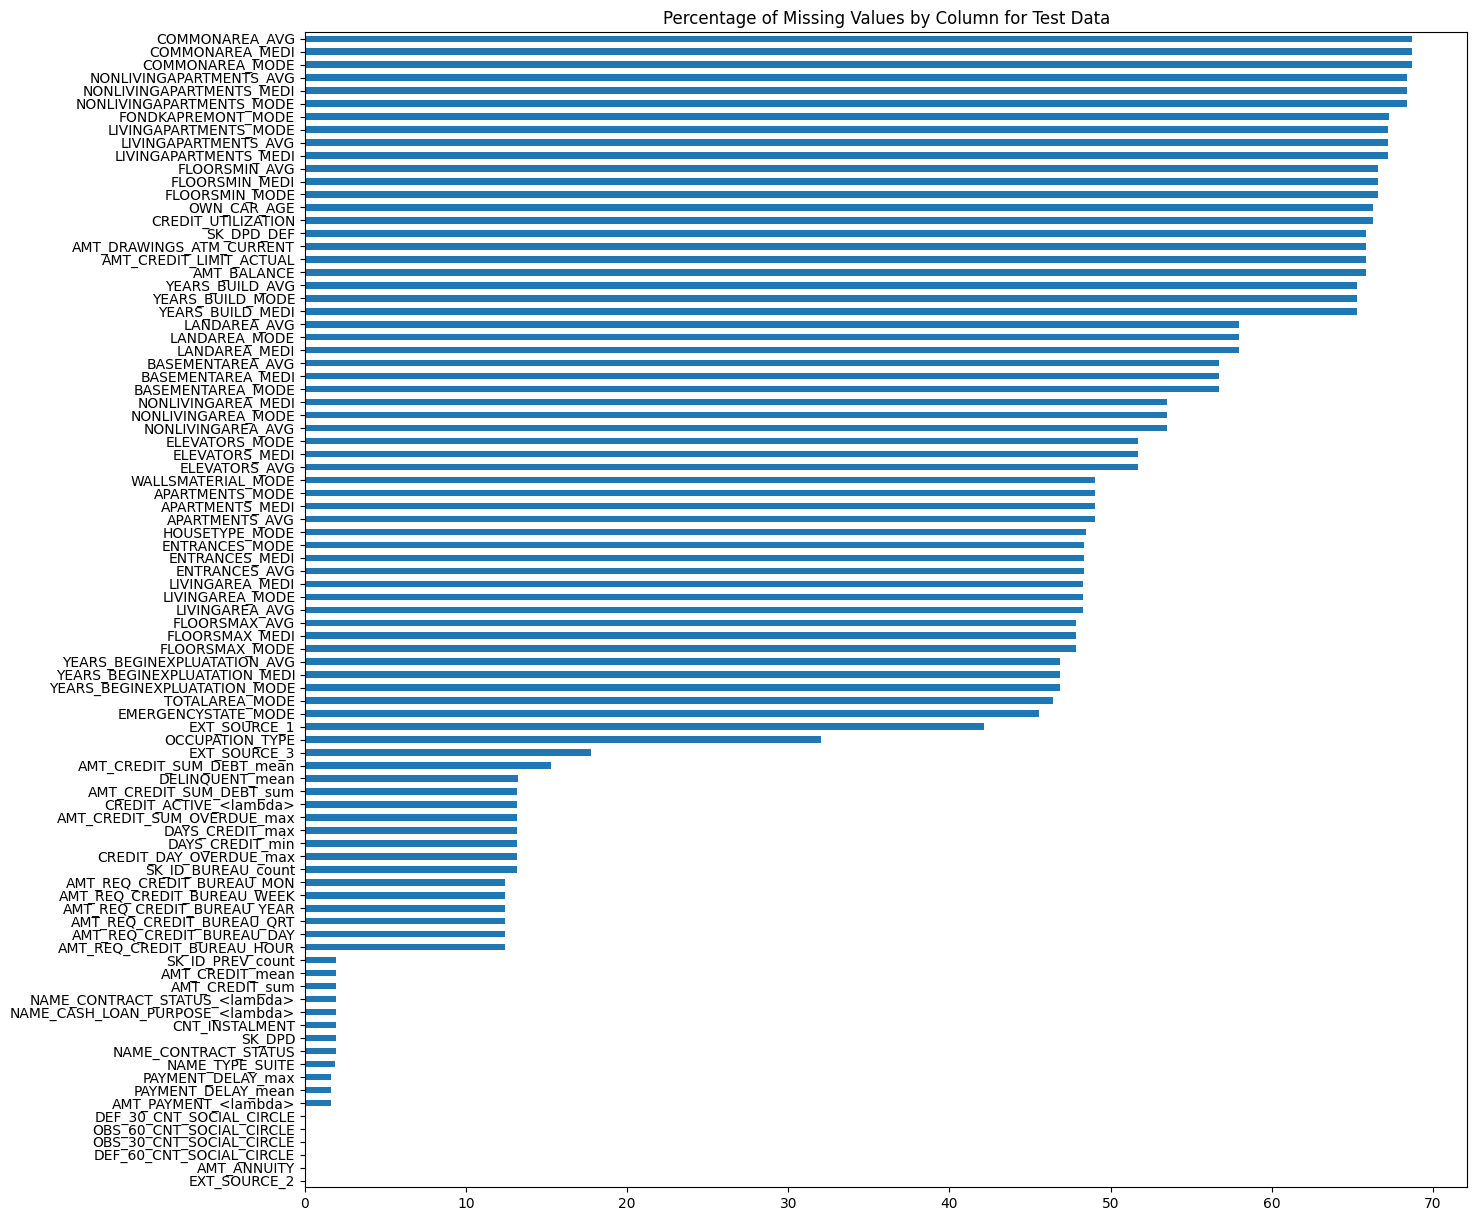

Numeric columns needing imputation: ['CREDIT_UTILIZATION', 'AMT_DRAWINGS_ATM_CURRENT', 'SK_DPD_DEF', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_BALANCE', 'DELINQUENT_mean', 'COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'APARTMENTS_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'Y

In [13]:
# --- Handling missing data ---

missing_percentage = (train_df.isnull().sum() / len(train_df)) * 100
print(missing_percentage.sort_values().round(3))  # Rounds to 3 decimal places

missing_percentage[missing_percentage > 0].sort_values().plot(
    kind='barh', 
    figsize=(10, 10),
    title='Percentage of Missing Values by Column for Train Data'
)
plt.show()


missing_percentage = (test_df.isnull().sum() / len(test_df)) * 100
print(missing_percentage.sort_values().round(3))  # Rounds to 3 decimal places

missing_percentage[missing_percentage > 0].sort_values().plot(
    kind='barh', 
    figsize=(15, 15),
    title='Percentage of Missing Values by Column for Test Data'
)
plt.show()

# Handle infinite values
train_df = train_df.replace([np.inf, -np.inf], np.nan)
test_df = test_df.replace([np.inf, -np.inf], np.nan)

# Calculate missing percentages for both datasets
train_missing = (train_df.isnull().mean() * 100).sort_values(ascending=False)
test_missing = (test_df.isnull().mean() * 100).sort_values(ascending=False)

# Identify columns with missing values
missing_cols = train_missing[train_missing > 0].index.tolist()

# Separate numeric and categorical columns with missing values
num_cols_missing = train_df[missing_cols].select_dtypes(include=np.number).columns.tolist()
cat_cols_missing = train_df[missing_cols].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric columns needing imputation: {num_cols_missing}")
print(f"Categorical columns needing imputation: {cat_cols_missing}")

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')  # More robust than mean for skewed data
train_df[num_cols_missing] = num_imputer.fit_transform(train_df[num_cols_missing])
test_df[num_cols_missing] = num_imputer.transform(test_df[num_cols_missing])

cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_cols_missing] = cat_imputer.fit_transform(train_df[cat_cols_missing])
test_df[cat_cols_missing] = cat_imputer.transform(test_df[cat_cols_missing])


In [14]:
# --- Encoding ---

# Initialize the encoder to handle feature names
onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='if_binary'
)

# --- Process the training data ---
train_categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
print(f"Training categorical columns: {train_categorical_cols}")

print("\n --- Overview of categorical columns for training data---")
for col in train_categorical_cols:
    unique_values = train_df[col].unique()
    print(f"- {col} ({len(unique_values)} unique values): {unique_values}")

# Fit on training data
onehot_encoder.fit(train_df[train_categorical_cols])

# Transform training data
train_encoded = onehot_encoder.transform(train_df[train_categorical_cols])
train_encoded_df = pd.DataFrame(
    train_encoded,
    columns=onehot_encoder.get_feature_names_out(train_categorical_cols),
    index=train_df.index
)

# --- Process the test data ---
test_categorical_cols = [col for col in test_df.columns 
                        if col in train_categorical_cols]  # Only use columns present in training
print(f"\nTest categorical columns (matching training): {test_categorical_cols}")

print("\n --- Overview of categorical columns for test data---")
for col in test_categorical_cols:
    unique_values = test_df[col].unique()
    print(f"- {col} ({len(unique_values)} unique values): {unique_values}")

test_encoded = onehot_encoder.transform(test_df[test_categorical_cols])
test_encoded_df = pd.DataFrame(
    test_encoded,
    columns=onehot_encoder.get_feature_names_out(train_categorical_cols),  # Use training columns
    index=test_df.index
)

# Combine with original data
train_df = pd.concat([
    train_df.drop(columns=train_categorical_cols),
    train_encoded_df
], axis=1)

test_df = pd.concat([
    test_df.drop(columns=test_categorical_cols),
    test_encoded_df
], axis=1)

print("\nFinal shapes:")
print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Training categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'NAME_CASH_LOAN_PURPOSE_<lambda>']

 --- Overview of categorical columns for training data---
- NAME_CONTRACT_TYPE (2 unique values): ['Cash loans' 'Revolving loans']
- CODE_GENDER (3 unique values): ['M' 'F' 'XNA']
- FLAG_OWN_CAR (2 unique values): ['N' 'Y']
- FLAG_OWN_REALTY (2 unique values): ['Y' 'N']
- NAME_TYPE_SUITE (7 unique values): ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
- NAME_INCOME_TYPE (8 unique values): ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
- NAME_EDUCATION_TYPE (5 unique values): 

TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    282686
1     24825
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of TARGET'}>

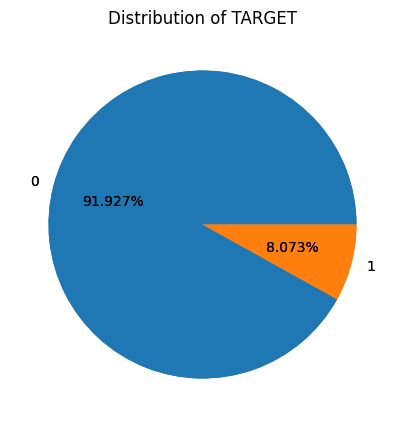

In [15]:
# --- Distribution of TARGET ---
plt.title("Distribution of TARGET")
print(train_df['TARGET'].value_counts())
train_df.groupby('TARGET').size().plot(kind='pie', autopct='%1.3f%%', figsize=(5, 5))

plt.title("Distribution of TARGET")
print(train_df['TARGET'].value_counts())
train_df.groupby('TARGET').size().plot(kind='pie', autopct='%1.3f%%', figsize=(5, 5))


# 4. Model Building

In [16]:
from sklearn.model_selection import train_test_split

# Prepare data
X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_df['TARGET']

# Split before balancing to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=33, stratify=y
)

# Combine X_train and y_train for processing
train_data = pd.concat([X_train, y_train], axis=1)

# Separate classes
majority = train_data[train_data['TARGET'] == 0]
minority = train_data[train_data['TARGET'] == 1]

# Oversample minority class
minority_upsampled = minority.sample(
    n=len(majority), 
    replace=True,    
    random_state=8
)

# Combine back
balanced_train = pd.concat([majority, minority_upsampled])

# Shuffle the data
balanced_train = balanced_train.sample(frac=1, random_state=33)

# Split back into X and y
X_res = balanced_train.drop('TARGET', axis=1)
y_res = balanced_train['TARGET']

print("Balanced dataset counts:")
print(y_res.value_counts())



Balanced dataset counts:
TARGET
0    226148
1    226148
Name: count, dtype: int64


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# debugging purpose - check non-numeri columns
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", list(non_numeric_cols))

Non-numeric columns: []


In [18]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_test)[:,1] # select the probability of class 1 only

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10,random_state=101,min_samples_leaf=15)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:,1]

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)
y_pred_lda = lda.predict_proba(X_test)[:,1]

In [21]:
import re 

def clean_column_names(df):
    # Replace ALL non-alphanumeric/underscore chars with '_'
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    
    # Ensure names don't start with a number (XGBoost/LightGBM dislike this)
    df.columns = [f'feature_{col}' if col[0].isdigit() else col for col in df.columns]
    
    # Remove duplicate underscores (e.g., "credit__limit" -> "credit_limit")
    df.columns = [re.sub(r'_+', '_', col) for col in df.columns]
    
    # Strip trailing/leading underscores (e.g., "_income_" -> "income")
    df.columns = [col.strip('_') for col in df.columns]
    
    return df

# This is to resolve the naming issue
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

In [22]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_pred_xgbc = xgbc.predict_proba(X_test)[:,1]

In [23]:
# import lightgbm as lgb 
# import re
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import (accuracy_score, classification_report, 
#                              confusion_matrix, roc_auc_score)


# # Create the base model
# lgb_model = lgb.LGBMClassifier(
#     objective='binary',  # Change for regression/multi-class
#     metric='binary_logloss',
#     n_estimators=1000,  # Large number since we use early stopping
#     random_state=42
# )



# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [15, 31, 63],
#     'max_depth': [-1, 5, 10],
#     'min_data_in_leaf': [10, 20, 50],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'bagging_freq': [0, 5]
# }

# random_search = RandomizedSearchCV(
#     estimator=lgb_model,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of random trials (adjust as needed)
#     cv=3,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=2
# )

# random_search.fit(X_train, y_train)

# # Best parameters from grid search
# best_params = grid_search.best_params_
# print("\nBest parameters found:")
# print(best_params)

# # ========== Train Final Model with Best Parameters ==========
# final_model = lgb.LGBMClassifier(
#     **best_params,
#     n_estimators=1000,
#     random_state=42
# )

# final_model.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_test, y_test)],
#     early_stopping_rounds=50,
#     verbose=10
# )

# # Probability predictions
# y_pred_lgbm = final_model.predict_proba(X_test)[:, 1]

# print("\nModel Evaluation:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# print("\nFeature Importance:")
# importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': final_model.feature_importances_
# }).sort_values('Importance', ascending=False)
# print(importance.head(10))

# final_model.booster_.save_model('best_lightgbm_model.txt')

In [24]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'dart',
    'learning_rate': 0.02,
    'num_leaves': 50,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'scale_pos_weight': 2,
    'reg_alpha': 0.05,
    'reg_lambda': 0.1,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose': -1
}


final_model = lgb.LGBMClassifier(**params)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
)

# Generate predictions
y_pred_lgm = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)

# Model evaluation
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_lgm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(importance.head(10))

# Save model
final_model.booster_.save_model('best_lightgbm_model.txt')


Model Evaluation:
Accuracy: 0.9196
AUC Score: 0.7632

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56588
           1       0.48      0.07      0.12      4915

    accuracy                           0.92     61503
   macro avg       0.70      0.53      0.54     61503
weighted avg       0.89      0.92      0.89     61503


Confusion Matrix:
[[56212   376]
 [ 4571   344]]

Top 10 Features:
                         Feature  Importance
27                  EXT_SOURCE_1        4461
28                  EXT_SOURCE_2        4130
29                  EXT_SOURCE_3        3857
6                     DAYS_BIRTH        2270
127           CREDIT_UTILIZATION        2221
114  NAME_CONTRACT_STATUS_lambda        1824
121            PAYMENT_DELAY_max        1687
7                  DAYS_EMPLOYED        1514
3                    AMT_ANNUITY        1480
115               AMT_CREDIT_sum        1398


# 5. Evaluation

/tmp/ipykernel_105/2868379955.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Modern style


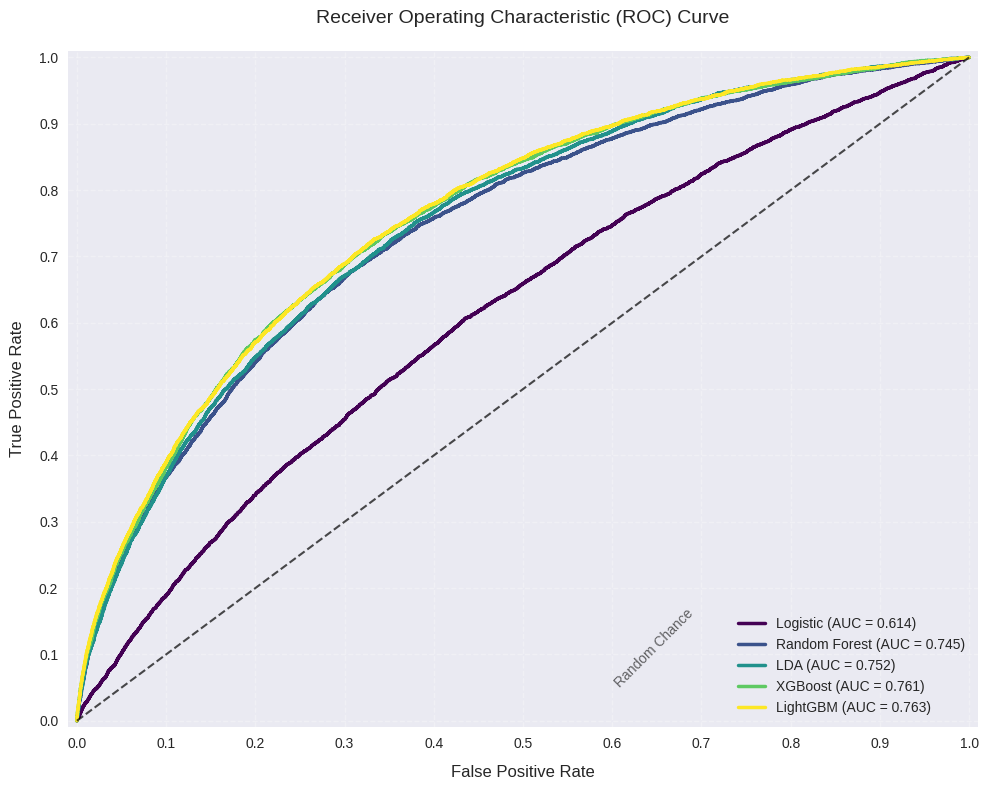

In [25]:
from sklearn.metrics import roc_curve, auc


# Assuming you have these predictions from different models
y_pred_array = [y_pred_lr, y_pred_rf, y_pred_lda, y_pred_xgbc, y_pred_lgm]
model_names = ['Logistic', 'Random Forest', 'LDA', 'XGBoost', 'LightGBM']

# Create figure with better aesthetics
plt.figure(figsize=(10, 8))
plt.style.use('seaborn')  # Modern style

# Colors for each model (using a perceptually uniform colormap)
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

# Plot ROC for each model
for i, (y_pred, name, color) in enumerate(zip(y_pred_array, model_names, colors)):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot with thicker lines for better visibility
    plt.plot(fpr, tpr, color=color, lw=2.5, 
             label=f'{name} (AUC = {roc_auc:.3f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)

# Enhancements
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=12, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=12, labelpad=10)
plt.title('Receiver Operating Characteristic (ROC) Curve', 
          fontsize=14, pad=20)

# Better legend
legend = plt.legend(loc='lower right', fontsize=10, framealpha=1)
legend.get_frame().set_edgecolor('black')

# Grid and ticks
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))

# Add some annotations
plt.text(0.6, 0.05, 'Random Chance', rotation=45, 
         fontsize=10, alpha=0.7)

# Tight layout and save option
plt.tight_layout()
plt.savefig('ROC_Curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
test_set = test_df.loc[:, test_df.columns != 'SK_ID_CURR']

y_pred = final_model.predict_proba(test_set)[:, 1]

res=pd.DataFrame(y_pred)
print(res.head())
res.set_index(test_df['SK_ID_CURR'], inplace=True) # add the index back
res.columns=['TARGET']
res.to_csv("/kaggle/working/prediction.csv")

          0
0  0.115747
1  0.238437
2  0.078129
3  0.096730
4  0.279825
